In [188]:
% reset
import tensorflow as tf
import numpy as np
from tensorflow.python.ops import math_ops
import matplotlib.pyplot as plt
import time
import os
import midi_musical_matrix
import data
import multi_training
from tensorflow.contrib.rnn import BasicLSTMCell
from tensorflow.contrib.rnn import LSTMStateTuple
from MyFunctions import Input_Kernel, LSTM_TimeWise_Training_Layer, LSTM_NoteWise_Layer, Loss_Function

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2


Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
# Import All Training Data
# Convert Entire Music .MIDI set to list of musical 'pieces'
# During training runs, getPieceBatch will return a tensor for Note_State_Batch, and corresponding Note_State_Expand
# Note_State_Expand will be fed into the graph input, and Note_State_Batch will be used for the loss function.

# Import Midi files to list
Working_Directory = os.getcwd()
Training_Midi_Folder = Working_Directory + "/Midi_Files/Bach_Handpicked"
max_time_steps = 256 # only files atleast this many 16th note steps are saved

practice_batch_size = 15
practice_num_timesteps = 128


training_pieces = multi_training.loadPieces(Training_Midi_Folder, max_time_steps)
print('')
print('Number of training pieces = ', len(training_pieces))

# Generate sample Note State Matrix for dimension measurement and numerical checking purposes
# (Using external code to generate the Note State Matrix but using our own NoteInputForm (as defined in author's code) function
_, sample_state = multi_training.getPieceBatch(training_pieces, practice_batch_size, practice_num_timesteps)
sample_state = np.array(sample_state)
sample_state = np.swapaxes(sample_state, axis1=1, axis2=2)
print('Sample of State Input Batch: shape = ', sample_state.shape)


Loaded Fugue1 (1)
Loaded Fugue1
Skip bad file =  Fugue11
Loaded Fugue12 (1)
Skip bad file =  Fugue12
Skip bad file =  Fugue13
Skip bad file =  Fugue15
Loaded Fugue16
Loaded Fugue17
Loaded Fugue18
Skip bad file =  Fugue19
Loaded Fugue2
Loaded Fugue20
Loaded Fugue22
Loaded Fugue23
Loaded Fugue24
Loaded Fugue3 (1)
Loaded Fugue3
Loaded Fugue4
Loaded Fugue5 (1)
Loaded Fugue5
Skip bad file =  Fugue6
Loaded Fugue7 (1)
Loaded Fugue7
Loaded Fugue8 (1)
Loaded Fugue8
Loaded Fugue9 (1)
Loaded Fugue9

Number of training pieces =  22
Sample of State Input Batch: shape =  (15, 78, 128, 2)


In [190]:
# Beginning of Model Graph:
tf.reset_default_graph()

#input_size = sample_state.shape[-1]
num_notes = sample_state.shape[1]


#place holder inputs
# num_batches and num_time steps are variable lengths.  These values do not affect the model parameters
# Dimension(0) =  num_batches. Dimension(2) = num_time_steps

#final_t_sample_run = np.zeros((batch_size, num_notes, 1, 2)) #start every batch with zero previous input


        
Note_State_Batch = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 2])
#prev_t_sample = tf.placeholder(dtype=tf.float32, shape=[None, num_notes,1,2])
time_init = tf.placeholder(dtype=tf.int32, shape=())
#Generates expanded tensor input to LSTM-timewise layer
Note_State_Expand = Input_Kernel(Note_State_Batch, Midi_low=24, Midi_high=101, time_init=time_init)

print('Note_State_Batch Placeholder Shape = ', Note_State_Batch.get_shape())
print('Note_State_Expand output Shape = ', Note_State_Expand.get_shape())





Note_State_Batch Placeholder Shape =  (?, 78, ?, 2)
Note_State_Expand output Shape =  (?, 78, ?, 80)


In [191]:
# Check Input Kernel on sample data

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sample_expand = sess.run(Note_State_Expand, feed_dict={Note_State_Batch: sample_state, time_init: 1})



#check MIDI note
print('sample_expand shape = ', sample_expand.shape)
print('MIDI note_0, t_0 = ', sample_expand[0,0,0,[0]]) 
print('MIDI note_1, t_0 = ', sample_expand[0,1,0,[0]])  
print('MIDI note_2, t_0 = ', sample_expand[0,2,0,[0]]) 

print('MIDI note_0, t_0 = ', sample_expand[0,0,0,[0]]) 
print('MIDI note_0, t_1 = ', sample_expand[0,0,1,[0]])  
print('MIDI note_0, t_29 = ', sample_expand[0,0,29,[0]]) 
print('') 

#check pitchclass
print('pitchclass note_0, t_0 = ', sample_expand[0,0,0,1:13]) 
print('pitchclass note_1, t_0 = ', sample_expand[0,1,0,1:13])  
print('pitchclass note_11, t_0 = ', sample_expand[0,11,0,1:13]) 

print('pitchclass note_0, t_0 = ', sample_expand[0,0,0,1:13]) 
print('pitchclass note_0, t_1 = ', sample_expand[0,0,1,1:13])  
print('pitchclass note_0, t_29 = ', sample_expand[0,0,29,1:13]) 
print('') 

#check vicinity
print('sample state local vicinity = ', sample_state[0,33:58,29,:])
print('calculated vicinity note_45, t_29 = ', sample_expand[0,45,29,13:63])
print('')

#check  context
print('calculated context note_45, t_29 = ', sample_expand[0,45,29,63:75])
print('actual all note plays at, t_29 = ', sample_state[0,:,29,0])
print('')

#check beat
print('beat note_0, t_0 = ', sample_expand[0,0,0,75:79]) 
print('beat note_1, t_0 = ', sample_expand[0,1,0,75:79])  
print('beat note_2, t_0 = ', sample_expand[0,2,0,75:79]) 

print('beat note_0, t_0 = ', sample_expand[0,0,0,75:79]) 
print('beat note_0, t_1 = ', sample_expand[0,0,1,75:79])  
print('beat note_0, t_29 = ', sample_expand[0,0,29,75:79]) 
print('')


sample_expand shape =  (15, 78, 128, 80)
MIDI note_0, t_0 =  [ 24.]
MIDI note_1, t_0 =  [ 25.]
MIDI note_2, t_0 =  [ 26.]
MIDI note_0, t_0 =  [ 24.]
MIDI note_0, t_1 =  [ 24.]
MIDI note_0, t_29 =  [ 24.]

pitchclass note_0, t_0 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_1, t_0 =  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_11, t_0 =  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
pitchclass note_0, t_0 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_0, t_1 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_0, t_29 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

sample state local vicinity =  [[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
calculated vicinity note_45, t_29 =  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0

In [192]:
#lSTM Time Wise Training Graph 
#tf.reset_default_graph()
#Note_State_Expand = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 80])
#Note_State_Expand_val = np.ones((10,78,128,80))

num_t_units=[200, 200]
output_keep_prob = tf.placeholder(dtype=tf.float32, shape=())

# Generate initial state (at t=0) placeholder
timewise_state=[]
for i in range(len(num_t_units)):
    timewise_c=tf.placeholder(dtype=tf.float32, shape=[None, num_t_units[i]]) #None = batch_size * num_notes
    timewise_h=tf.placeholder(dtype=tf.float32, shape=[None, num_t_units[i]])
    timewise_state.append(LSTMStateTuple(timewise_h, timewise_c))

timewise_state=tuple(timewise_state)


timewise_out, timewise_state_out = LSTM_TimeWise_Training_Layer(input_data=Note_State_Expand, state_init=timewise_state, output_keep_prob=output_keep_prob)


print('Time-wise output shape = ', timewise_out.get_shape())
print(len(timewise_state_out))



Time-wise output shape =  (?, 78, ?, 200)
2


In [193]:
#LSTM Note Wise Graph
#tf.reset_default_graph()
#num_notes=78
#timewise_out = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 50])
#output_keep_prob=1
num_n_units = [100, 100]

# Generate initial state (at n=0) placeholder
notewise_state=[]
for i in range(len(num_n_units)):
    notewise_c=tf.placeholder(dtype=tf.float32, shape=[None, num_n_units[i]]) #None = batch_size * num_timesteps
    notewise_h=tf.placeholder(dtype=tf.float32, shape=[None, num_n_units[i]])
    notewise_state.append(LSTMStateTuple(notewise_h, notewise_c))

notewise_state=tuple(notewise_state)


y_out, note_gen_out = LSTM_NoteWise_Layer(timewise_out, state_init=notewise_state, output_keep_prob=output_keep_prob)


print('y_out shape = ', y_out.get_shape())
print('generated samples shape = ', note_gen_out.get_shape())




y_out shape =  (?, 78, ?, 2, 2)
generated samples shape =  (?, 78, ?, 2)


In [30]:
# Test for Notewise-LSTM
#num_timesteps=5
#batch_size=7
#timewise_out_val = np.random.randn(batch_size, 78, num_timesteps, 50)*10

#notewise_state_val=[]
#for i in range(len(num_n_units)):
#    c_n = np.zeros((batch_size*num_timesteps, num_n_units[i])) #start every batch with zero state in LSTM time cells
#    h_n = np.zeros((batch_size*num_timesteps, num_n_units[i]))
#    notewise_state_val.append(LSTMStateTuple(h_n, c_n))

#with tf.Session() as sess:
#    sess.run(tf.global_variables_initializer())
#    feed_dict = {timewise_out: timewise_out_val, notewise_state: notewise_state_val}
#    y_out_run, note_gen_out_run = sess.run([y_out, note_gen_out], feed_dict=feed_dict)


In [194]:
# Loss Function and Optimizer

#y_out_val = np.random.randn(1, 78, 128, 2, 2)*5


loss, cross_entropy = Loss_Function(Note_State_Batch, y_out)
optimizer = tf.train.AdadeltaOptimizer(learning_rate = 1).minimize(loss)



#with tf.Session() as sess:
#    sess.run(tf.global_variables_initializer())
#    cross_entropy_out, loss_out = sess.run([cross_entropy, loss], feed_dict={y_out: y_out_val, Note_State_Batch: batch_input_state})
print('cross entropy shape = ', cross_entropy.get_shape())


y_align shape = :  (?, ?, ?, ?, ?)
Note_State_Batch_align shape = :  (?, ?, ?, ?)
cross entropy shape =  (?, ?, ?, ?)


In [195]:
# Training
N_epochs = 10
loss_hist=[]
restore_model_name = None
save_model_name = 'Practice'
batch_size = 10
num_timesteps = 128
keep_prob=.75

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    # try to restore the pre_trained
    if restore_model_name is not None:
        print("Load the model from: {}".format(restore_model_name))
        saver.restore(sess, 'model/{}'.format(restore_model_name))
    
    # Initial States
    timewise_state_val=[]
    for i in range(len(num_t_units)):
        c_t = np.zeros((batch_size*num_notes, num_t_units[i])) #start every batch with zero state in LSTM time cells
        h_t = np.zeros((batch_size*num_notes, num_t_units[i]))
        timewise_state_val.append(LSTMStateTuple(h_t, c_t))
        
    notewise_state_val=[]
    for i in range(len(num_n_units)):
        c_n = np.zeros((batch_size*num_timesteps, num_n_units[i])) #start every batch with zero state in LSTM time cells
        h_n = np.zeros((batch_size*num_timesteps, num_n_units[i]))
        notewise_state_val.append(LSTMStateTuple(h_n, c_n))
    
  

    # Training Loop
    for epoch in range(N_epochs):
        
        #Generate random batch of training data
        
        if epoch % 100 == 0:         
            print('Obtaining new batch of pieces')
            _, batch_input_state = multi_training.getPieceBatch(training_pieces, batch_size, num_timesteps) # not using their 'convolution' filter
            batch_input_state = np.array(batch_input_state)
            batch_input_state = np.swapaxes(batch_input_state, axis1=1, axis2=2)           
            print('sum = ',sum(sum(sum(sum(batch_input_state)))) )
        
        """
        print('Note_State_Batch shape = ', Note_State_Batch.get_shape())
        print('batch_input_state shape = ', batch_input_state.shape)
        print('')
        print('timewise_state shape = ', Note_State_Batch.get_shape())
        print('timewise_state_val shape = ', batch_input_state.shape)      
        print('')
        print('notewise_state shape = ', Note_State_Batch.get_shape())
        print('notewise_state_val shape = ', batch_input_state.shape)
        ('')
        print('time_init shape = ', time_init.get_shape())
        """
    
        feed_dict = {Note_State_Batch: batch_input_state, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: 0, output_keep_prob: keep_prob}
        #try:
        loss_run, _, note_gen_out_run = sess.run([loss, optimizer, note_gen_out], feed_dict=feed_dict)
        #except:
        #   save_path = saver.save(sess, 'model/{}'.format(save_model_name))
        #    print("Model saved in file: %s" % save_path)
        
        print('epoch = ', epoch, '; loss = ', loss_run)
        loss_hist.append(loss_run)
        
        if epoch % 100 == 0 & epoch > 0:
            save_path = saver.save(sess, 'model/{}'.format(save_model_name))
            print("Model saved in file: %s" % save_path)
            
    #save_path = saver.save(sess, 'model/{}'.format(save_model_name))
    #print(" Final Model saved in file: %s" % save_path)


Obtaining new batch of pieces
sum =  5781
epoch =  0 ; loss =  0.70159
epoch =  1 ; loss =  0.678908
epoch =  2 ; loss =  0.661829
epoch =  3 ; loss =  0.645072
epoch =  4 ; loss =  0.627301
epoch =  5 ; loss =  0.607991


KeyboardInterrupt: 

In [187]:


#print(square_error/mag)
#print('Actual input = ', batch_input_state[:,:,1,:])
#print('Output predicting this input = ', note_gen_out_run[:,:,0,:])
error = sum(sum(sum(abs(batch_input_state[:,:,1:,:] - note_gen_out_run[:,:,:-1,:]))))
num_1 = sum(sum(sum(abs(batch_input_state[:,:,1:,:]))))
print('error = ', error)
print('num_1 = ', num_1)
#for v in range(len(tf.trainable_variables())):
#    print(tf.trainable_variables()[v])

error =  [1 0]
num_1 =  [20  2]


1000

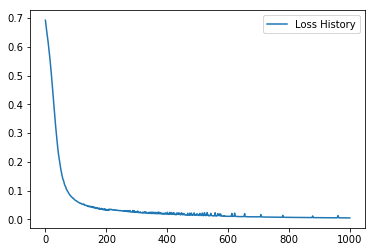

In [154]:
plt.plot(loss_hist, label="Loss History")
plt.legend()
plt.show
len(loss_hist)

In [10]:
# Music Generation
# input = initial note vector
# for t = 1:Tsong
#    input --> input kernel
#    run through 1 'call' of Model LSTM with present parameters / states
#    run through note-wise LSTM block as normally done to produce vector of generated samples
#    input = generated samples
#    music_sequence.append(input)

# store batch of music sequences in .MIDI files


#Load Model
restore_model_name = 'NoteGen_Fix'

#Length of generated music
T_gen = 16*16
batch_gen_size = 5
keep_prob = 1

# start with initial Note_State_Batch with 't' dimension = 1 (can still a batch of samples run in parallel)
notes_gen_initial = np.zeros((batch_gen_size, num_notes, 1,2))

# Initial States
notes_gen = notes_gen_initial
    
timewise_state_val=[]
for i in range(len(num_t_units)):
    c = np.zeros((batch_gen_size*num_notes, num_t_units[i])) #start every batch with zero state in LSTM time cells
    h = np.zeros((batch_gen_size*num_notes, num_t_units[i]))
    timewise_state_val.append(LSTMStateTuple(h, c))
        
notewise_state_val=[]
for i in range(len(num_n_units)):
    c = np.zeros((batch_gen_size*1, num_n_units[i])) #start every batch with zero state in LSTM time cells
    h = np.zeros((batch_gen_size*1, num_n_units[i]))
    notewise_state_val.append(LSTMStateTuple(h, c))
        
notes_gen_arr=[]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    print("Load the model from: {}".format(restore_model_name))
    saver.restore(sess, 'model/{}'.format(restore_model_name))
    

    for t in range(T_gen):
        feed_dict = {Note_State_Batch: notes_gen, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: t % 16, output_keep_prob: keep_prob}    
        timewise_state_val, notes_gen = np.squeeze(sess.run([timewise_state_out, note_gen_out], feed_dict = feed_dict), axis=2)
        #print('notes_gen shape = ', notes_gen.shape)
        #notes_gen = np.squeeze(notes_gen, axis=2)
        notes_gen_arr.append(np.squeeze(notes_gen))
        
        
        
        if t % 50 == 0:
            print('Timestep = ', t)
    
notes_gen_out = np.stack(notes_gen_arr, axis=2)
print(notes_gen_out.shape)
        


Load the model from: NoteGen_Fix
INFO:tensorflow:Restoring parameters from model/NoteGen_Fix
Timestep =  0
Timestep =  50
Timestep =  100
Timestep =  150
Timestep =  200
Timestep =  250
(5, 78, 256, 2)


In [11]:
# Save Generate Notes to .MIDI file

notes_gen_out = np.swapaxes(notes_gen_out, axis1=1, axis2=2)
print(notes_gen_out.shape)
#_, notes_gen_out = Utils.multi_training.getPieceBatch(training_pieces)


#print(test_batch.shape)
for iter in range(3):
    file = 'Generated_Midi_Files/NoteGen_Fix' + str(iter)
    midi_out = midi_musical_matrix.noteStateMatrixToMidi(notes_gen_out[iter,:,:,:], name=file)

(5, 256, 78, 2)


Items to Experiment with:
- different T length or variable length T from batch-to-batch for training
- categorize music, either through (unsupervised) clustering or (supervised) labeled music folders.  For clustering, the model would possibly find 'k' 'centroids' in an unsupervised manner each with its own music distribution, so during the music generation stage, 1 of these centroids would be selected for a piece of music.  
- use encoder to reduce dimensionality of each note vector (vector of 79 notes in 1 time step), similiar to encoding the words from the tweets in homework 3 (i.e. there are restricted combinations of notes that can be played simultaneously)
- more advanced sampling/exploring for training/music generation.  This may help prevent the algorithm from getting 'stuck' on a chord, or 